In [1]:
import pandas as pd
import numpy as np

In [28]:
runners = pd.read_csv("raw-data-kaggle.csv", sep=";")

In [29]:
runners.head()

,athlete,gender,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm)
0,18042525,M,15/12/2019 09:08,2965.8,812,17.4,150.3
1,18042525,M,10/12/2019 19:27,10020.8,3290,52.2,160.8
2,18042525,M,03/12/2019 19:46,12132.2,4027,249.0,148.9
3,18042525,M,26/11/2019 19:46,11631.5,4442,194.0,136.2
4,18042525,M,19/11/2019 19:45,11708.1,4022,250.7,146.0


In [30]:
runners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42116 entries, 0 to 42115
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   athlete                   42116 non-null  int64  
 1   gender                    41761 non-null  object 
 2   timestamp                 42116 non-null  object 
 3   distance (m)              42116 non-null  float64
 4   elapsed time (s)          42116 non-null  int64  
 5   elevation gain (m)        42116 non-null  float64
 6   average heart rate (bpm)  23732 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 2.2+ MB


In [31]:
#Ritmo
runners["pace_min_km"] = (runners["elapsed time (s)"] / 60) / (runners["distance (m)"] / 1000)

In [32]:
#Elevación por KM
runners["elev_per_km"] = runners["elevation gain (m)"] / (runners["distance (m)"]/1000)

In [33]:
#Velocidad
runners["speed_kmh"] = 3.6 * runners["distance (m)"] / runners["elapsed time (s)"]

In [34]:
#Tiempo en minutos
runners["elapsed_min"] = runners["elapsed time (s)"] / 60

In [35]:
#Hora del día
runners["hour"] = pd.to_datetime(runners["timestamp"]).dt.hour

C:\Users\Asier\AppData\Local\Temp\ipykernel_3212\3182913642.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  runners["hour"] = pd.to_datetime(runners["timestamp"]).dt.hour


In [36]:
#Día de la semana
runners["weekday"] = pd.to_datetime(runners["timestamp"]).dt.weekday

C:\Users\Asier\AppData\Local\Temp\ipykernel_3212\845337199.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  runners["weekday"] = pd.to_datetime(runners["timestamp"]).dt.weekday


In [37]:
#Mes del año
runners["month"] = pd.to_datetime(runners["timestamp"]).dt.month

C:\Users\Asier\AppData\Local\Temp\ipykernel_3212\3081875461.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  runners["month"] = pd.to_datetime(runners["timestamp"]).dt.month


In [38]:
#Esfuerzo por la elevacion (para trail)
runners["elevation_effort"] = runners["elev_per_km"] * (runners["distance (m)"]/1000)


In [39]:
#Eficiencia, FC relativa al ritmo
runners["efficiency"] = runners["speed_kmh"] / runners["average heart rate (bpm)"]

In [41]:
#Zonas de ritmo
def pace_zone(p):
    if p < 4: return "fast"
    elif p < 5: return "moderate"
    elif p < 6: return "easy"
    else: return "very_easy"

runners["pace_zone"] = runners["pace_min_km"].apply(pace_zone)

In [42]:
#Zonas de FC
def hr_zone(hr):
    if hr < 120: return "Z1"
    elif hr < 140: return "Z2"
    elif hr < 160: return "Z3"
    elif hr < 180: return "Z4"
    else: return "Z5"

runners["hr_zone"] = runners["average heart rate (bpm)"].apply(hr_zone)

In [43]:
#Categoría de distancia
def dist_cat(d):
    km = d/1000
    if km < 10: return "short"
    elif km <= 21: return "medium"
    else: return "long"

runners["distance_category"] = runners["distance (m)"].apply(dist_cat)

In [44]:
#Separar Asfalto y Trail
runners["terrain"] = runners["elev_per_km"].apply(
    lambda x: "asphalt" if x <= 20 else "trail"
)

In [53]:
runners = runners[runners["pace_min_km"] <= 9]
runners = runners[runners["distance (m)"] <= 50000]  # 50 km
runners = runners[runners["distance (m)"] >= 3000]  # 3 km
runners = runners[runners["elev_per_km"] < 120]
runners = runners[runners["pace_min_km"] > 3]
runners = runners[~(
    (runners["elev_per_km"] > 30) &
    (runners["pace_min_km"] < 4)
)]
runners = runners[
    (runners["average heart rate (bpm)"] >= 120) &
    (runners["average heart rate (bpm)"] <= 195)
]
# Filtrar atletas con mínimo 20 entrenamientos
athlete_counts = runners["athlete"].value_counts()
valid_athletes = athlete_counts[athlete_counts >= 20].index

runners = runners[runners["athlete"].isin(valid_athletes)]

In [46]:
#Quitar nulos, que solo están en género y son muy pocos 1-2%
runners = runners.dropna(subset=["gender"])

In [47]:
runners_trail = runners[runners["terrain"] == "trail"]

In [48]:
runners_asphalt = runners[runners["terrain"] == "asphalt"]

In [49]:
runners.describe()

,athlete,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace_min_km,elev_per_km,speed_kmh,elapsed_min,hour,weekday,month,elevation_effort,efficiency
count,1.996900e+04,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000,19969.000000
mean,1.524551e+07,11305.001502,3858.619160,177.034453,150.140017,5.663564,13.556272,10.845282,64.310319,12.118383,3.151785,6.523361,177.034453,0.072671
std,8.899837e+06,5209.389680,2052.150633,269.163395,13.375294,0.894689,14.746499,1.639176,34.202511,4.454869,2.020936,3.582849,269.163395,0.011809
min,7.715140e+05,3000.000000,583.000000,0.000000,120.000000,3.011986,0.000000,6.668731,9.716667,0.000000,0.000000,1.000000,0.000000,0.037272
25%,6.367873e+06,8157.100000,2701.000000,35.500000,140.900000,5.067960,3.894898,9.841598,45.016667,8.000000,1.000000,3.000000,35.500000,0.065012
50%,1.500260e+07,10482.800000,3490.000000,83.000000,149.600000,5.552310,8.133937,10.806313,58.166667,12.000000,3.000000,6.000000,83.000000,0.072680
75%,2.129997e+07,13151.200000,4419.000000,210.000000,158.800000,6.096571,18.448736,11.839084,73.650000,16.000000,5.000000,10.000000,210.000000,0.080415
max,4.579977e+07,48378.800000,25380.000000,3135.000000,194.500000,8.997213,116.197906,19.920412,423.000000,23.000000,6.000000,12.000000,3135.000000,0.149329


In [23]:
runners.columns

Index(['athlete', 'gender', 'timestamp', 'distance (m)', 'elapsed time (s)',
       'elevation gain (m)', 'average heart rate (bpm)', 'pace_min_km',
       'elev_per_km', 'speed_kmh', 'elapsed_min', 'hour', 'weekday', 'month',
       'effort', 'efficiency', 'pace_zone', 'hr_zone', 'distance_category',
       'terrain'],
      dtype='object')

In [24]:
runners_numeric = runners.select_dtypes(include="number")
runners_numeric.corr()

,athlete,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace_min_km,elev_per_km,speed_kmh,elapsed_min,hour,weekday,month,effort,efficiency
athlete,1.000000,-0.059919,-0.007620,0.010439,0.042999,0.144307,0.015681,-0.136267,-0.007620,-0.036587,0.001859,0.057272,0.089663,-0.144777
distance (m),-0.059919,1.000000,0.927646,0.581002,0.050196,0.060877,0.309579,-0.036885,0.927646,-0.181335,0.240542,-0.048389,0.212639,-0.059656
elapsed time (s),-0.007620,0.927646,1.000000,0.758389,0.018242,0.384549,0.494909,-0.341832,1.000000,-0.194408,0.234952,-0.056466,0.508000,-0.323154
elevation gain (m),0.010439,0.581002,0.758389,1.000000,0.069834,0.493202,0.869998,-0.412936,0.758389,-0.184662,0.210576,-0.053408,0.776610,-0.419961
average heart rate (bpm),0.042999,0.050196,0.018242,0.069834,1.000000,-0.112273,0.080213,0.145427,0.018242,0.046139,0.116036,0.032988,-0.024571,-0.415249
pace_min_km,0.144307,0.060877,0.384549,0.493202,-0.112273,1.000000,0.546555,-0.970315,0.384549,-0.058155,0.037438,-0.033404,0.881808,-0.830457
elev_per_km,0.015681,0.309579,0.494909,0.869998,0.080213,0.546555,1.000000,-0.470367,0.494909,-0.114263,0.157463,-0.040079,0.867751,-0.479372
speed_kmh,-0.136267,-0.036885,-0.341832,-0.412936,0.145427,-0.970315,-0.470367,1.000000,-0.341832,0.030356,0.001489,0.032305,-0.808975,0.834272
elapsed_min,-0.007620,0.927646,1.000000,0.758389,0.018242,0.384549,0.494909,-0.341832,1.000000,-0.194408,0.234952,-0.056466,0.508000,-0.323154
hour,-0.036587,-0.181335,-0.194408,-0.184662,0.046139,-0.058155,-0.114263,0.030356,-0.194408,1.000000,-0.305781,-0.034533,-0.107102,0.003285


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

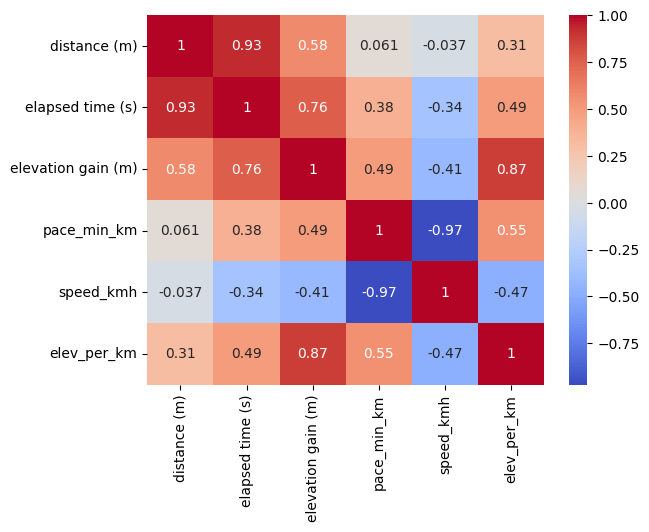

In [26]:
#Variables principales
cols_main = [
    "distance (m)", "elapsed time (s)", "elevation gain (m)",
    "pace_min_km", "speed_kmh", "elev_per_km"
]

sns.heatmap(runners[cols_main].corr(), annot=True, cmap="coolwarm")

<Axes: >

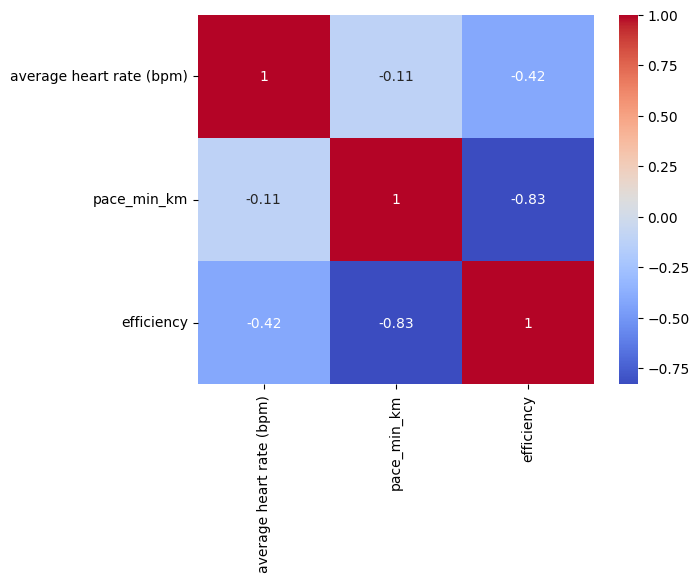

In [27]:
#Variables de FC y eficiencia
cols_hr = ["average heart rate (bpm)", "pace_min_km", "efficiency"]
sns.heatmap(runners[cols_hr].corr(), annot=True, cmap="coolwarm")

<Axes: >

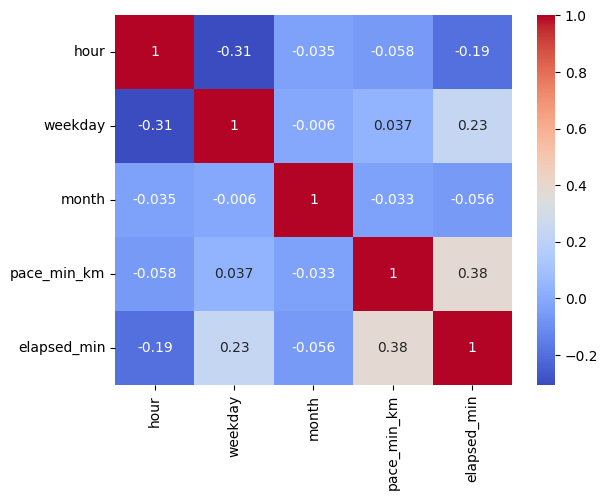

In [117]:
#Columnas temporales
cols_time = ["hour", "weekday", "month", "pace_min_km", "elapsed_min"]
sns.heatmap(runners[cols_time].corr(), annot=True, cmap="coolwarm")

<Axes: >

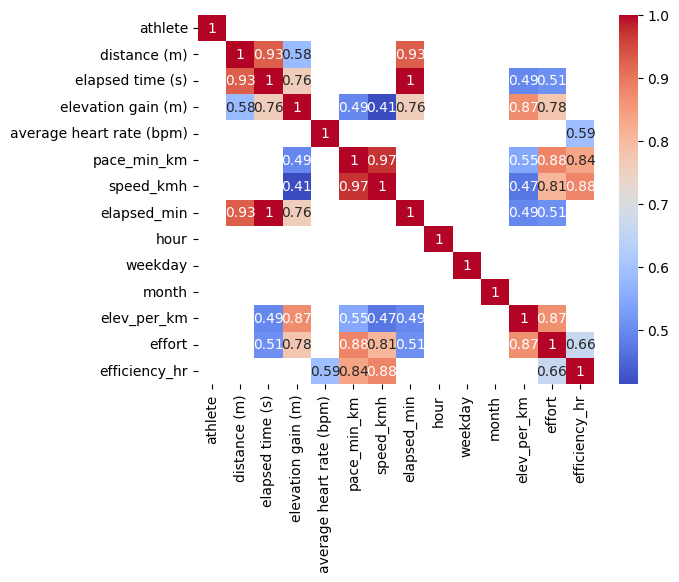

In [120]:
#Correlaciones fuertes
corr = runners_numeric.corr().abs()
strong_corr = corr[corr > 0.4]

sns.heatmap(strong_corr, annot=True, cmap="coolwarm")

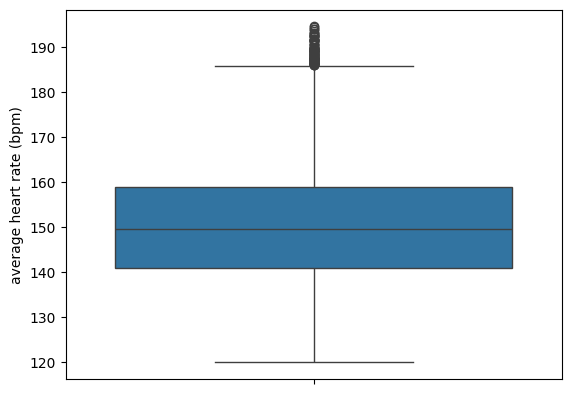

In [121]:
sns.boxplot(runners["average heart rate (bpm)"]);

In [55]:
runners[runners["athlete"] == 13435425]

,athlete,gender,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace_min_km,elev_per_km,speed_kmh,elapsed_min,hour,weekday,month,elevation_effort,efficiency,pace_zone,hr_zone,distance_category,terrain
35598,13435425,M,05/12/2019 15:08,15602.4,4354,95.1,121.9,4.650994,6.095216,12.900469,72.566667,15,3,12,95.1,0.105828,moderate,Z2,medium,asphalt
35722,13435425,M,27/07/2019 17:10,12361.8,2614,169.1,163.7,3.524298,13.679238,17.024667,43.566667,17,5,7,169.1,0.103999,fast,Z4,medium,asphalt
35792,13435425,M,28/04/2019 08:23,14305.1,3555,311.3,153.0,4.141879,21.761470,14.486177,59.250000,8,6,4,311.3,0.094681,moderate,Z3,medium,trail
35856,13435425,M,17/02/2019 07:07,17081.0,4584,173.3,147.8,4.472806,10.145776,13.414398,76.400000,7,6,2,173.3,0.090760,moderate,Z3,medium,asphalt
35933,13435425,M,10/12/2018 14:56,18577.3,5055,121.9,143.4,4.535105,6.561772,13.230125,84.250000,14,0,12,121.9,0.092260,moderate,Z3,medium,asphalt
36083,13435425,M,10/06/2018 07:29,15024.5,4037,84.0,129.3,4.478241,5.590868,13.398117,67.283333,7,6,6,84.0,0.103620,moderate,Z2,medium,asphalt
36149,13435425,M,08/04/2018 07:15,10062.8,1931,46.6,163.1,3.198248,4.630918,18.760269,32.183333,7,6,4,46.6,0.115023,fast,Z4,medium,asphalt
36166,13435425,M,19/03/2018 17:36,3817.9,1230,2.0,146.9,5.369444,0.523848,11.174341,20.500000,17,0,3,2.0,0.076068,easy,Z3,short,asphalt
36227,13435425,M,10/01/2018 06:29,16101.1,4561,71.9,129.3,4.721210,4.465533,12.708608,76.016667,6,2,1,71.9,0.098288,moderate,Z2,medium,asphalt
36303,13435425,M,15/10/2017 07:34,19913.5,4900,352.9,125.8,4.101070,17.721646,14.630327,81.666667,7,6,10,352.9,0.116298,moderate,Z2,medium,asphalt
